In [14]:
import os

metadata_folder_path = "models/saved_models_metadata"
num_models = len(os.listdir(metadata_folder_path))

print(f"Nombre de modèles : {num_models}")

Nombre de modèles : 200


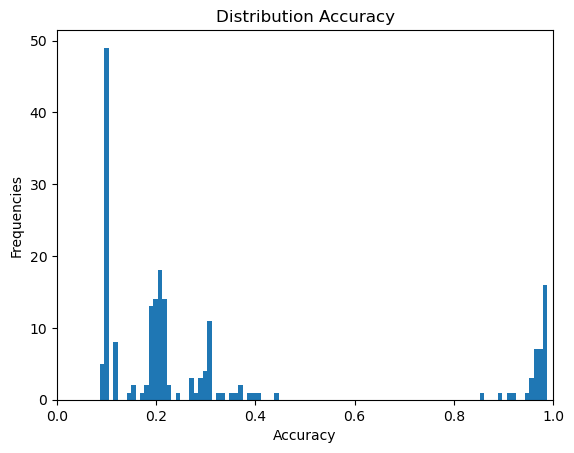

In [15]:
import matplotlib.pyplot as plt
import os
from scripts import load_metadata

metadata_folder_path = "models/saved_models_metadata"

metadata_file_names = os.listdir(metadata_folder_path)
accuracy_list = []

for metatata_files in metadata_file_names:
    metadata_path = os.path.join(metadata_folder_path, metatata_files)
    metadata = load_metadata(metadata_path)

    accuracy = metadata["Accuracy"]
    accuracy_list.append(accuracy)


plt.hist(accuracy_list, bins=100)


plt.xlim(0, 1)

plt.title("Distribution Accuracy")
plt.xlabel("Accuracy")
plt.ylabel("Frequencies")


plt.show()

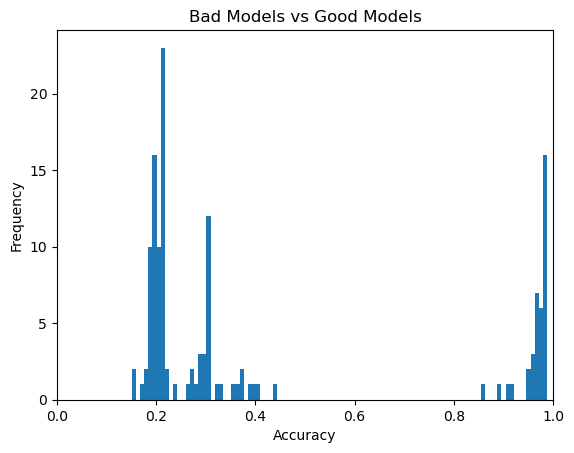

In [4]:
import matplotlib.pyplot as plt
import os

from scripts import load_metadata

metadata_folder_path = "models/saved_models_metadata"

metadata_file_names = os.listdir(metadata_folder_path)
accuracy_list = []

for metadata_file in metadata_file_names:  
    metadata_path = os.path.join(metadata_folder_path, metadata_file)
    metadata = load_metadata(metadata_path)

    accuracy = metadata["Accuracy"]
    if accuracy > 0.15:
        accuracy_list.append(accuracy)


plt.hist(accuracy_list, bins=100)
plt.xlim(0, 1)
plt.title("Bad Models vs Good Models")  
plt.xlabel("Accuracy")  
plt.ylabel("Frequency") 
plt.show()

In [16]:
import re


def find_uuid(file_name: str) -> str:
    pattern = r"model_([a-f0-9\-]+)\.pth"
    match = re.search(pattern, file_name)
    if match:
        extracted_string = match.group(1)
        return extracted_string
    else:
        None

# **Weight Aggregation and Distribution Formulas**

## **Weight Aggregation Across Models**

### Definitions
- **For a given layer, let:**
  - \( n \): Number of models.
  - \( \text{nb} \): Number of weights in the layer or the filters.
  - \( w_{i,j} \): The weight of the \( j \)-th parameter in the \( i \)-th model.

### Average Weight Formula
- **The average weight for the \( j \)-th parameter across all models is:**
  $$
  \bar{w}_j = \frac{1}{n} \sum_{i=1}^{n} w_{i,j}
  $$

- **This creates the set of averaged weights:**
  $$
  \{\bar{w}_1, \bar{w}_2, \dots, \bar{w}_{\text{nb}}\}
  $$

## **Plotting the Distribution**

### Distribution to Visualize
- **The distribution to be visualized is:**
  $$
  \{\bar{w}_1, \bar{w}_2, \dots, \bar{w}_{\text{nb}}\}
  $$

- **Where each \( \bar{w}_j \) is the mean of the weights for the \( j \)-th parameter across the \( n \) models.**

### Gaussian Fit
- **A histogram is plotted to show the frequency of these averaged weights, and a Gaussian fit is applied:**
  $$
  f(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{(x - \mu)^2}{2 \sigma^2}\right)
  $$

### Explanation of Gaussian Parameters
- \( \mu \): Mean of the weights.
- \( \sigma \): Standard deviation of the weights.

c:\Users\cypri\OneDrive - CentraleSupelec\Bureau\Non_Linear_Systems\scripts\utils.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model

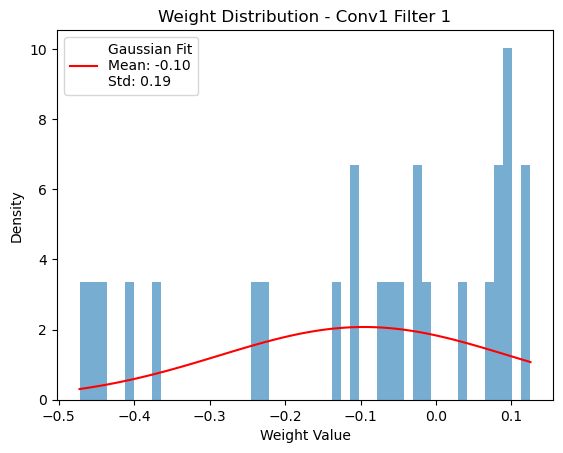

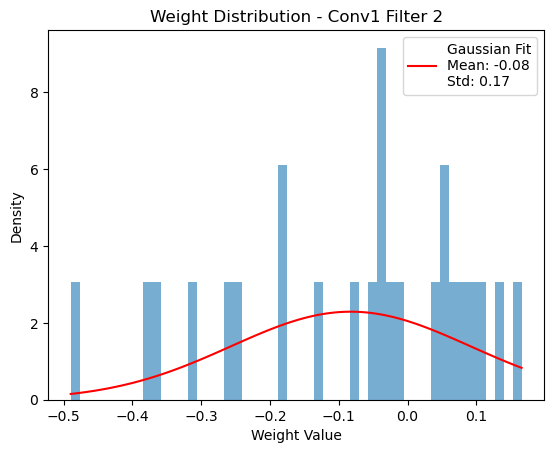

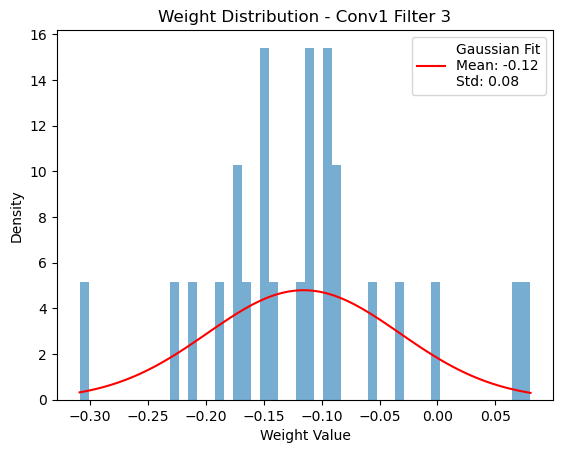

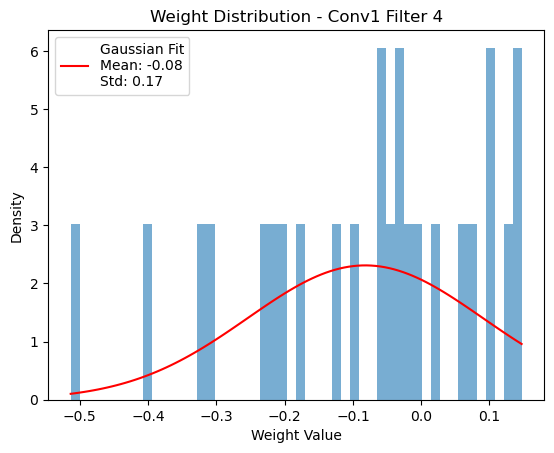

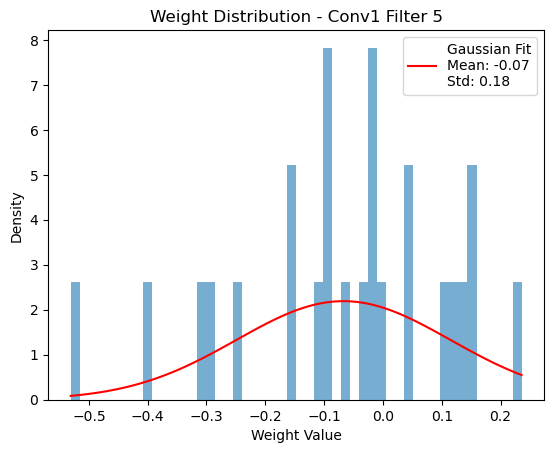

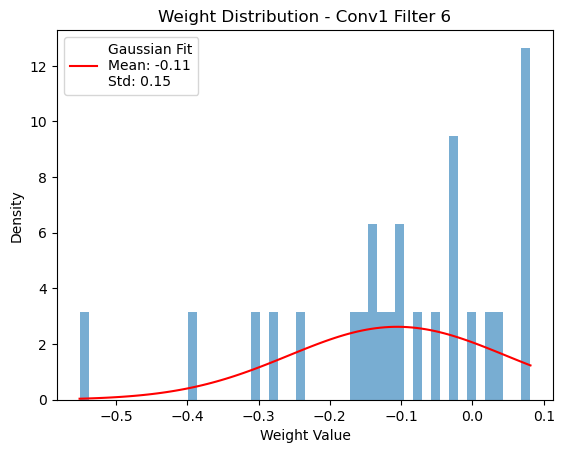

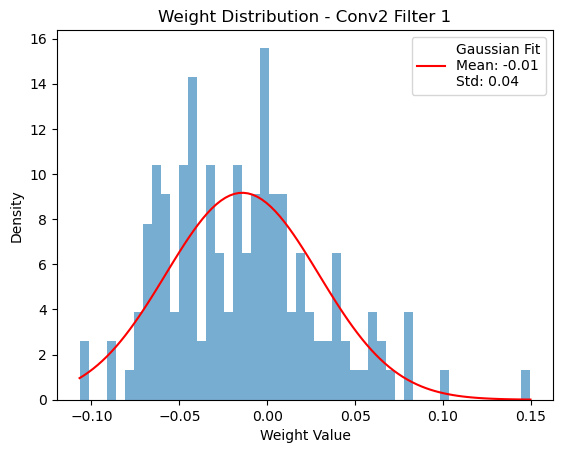

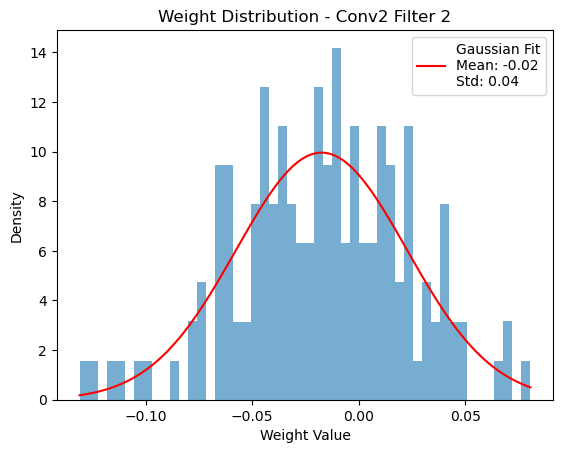

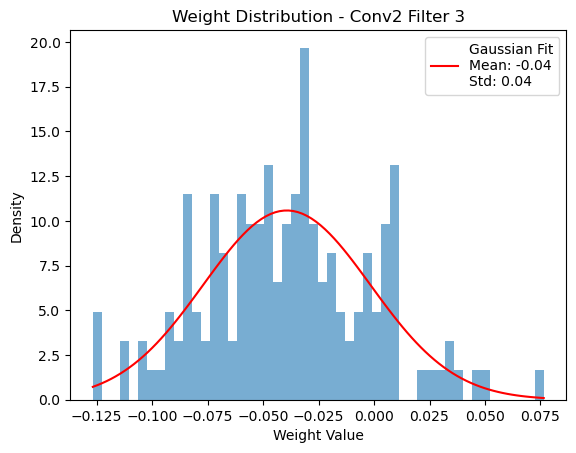

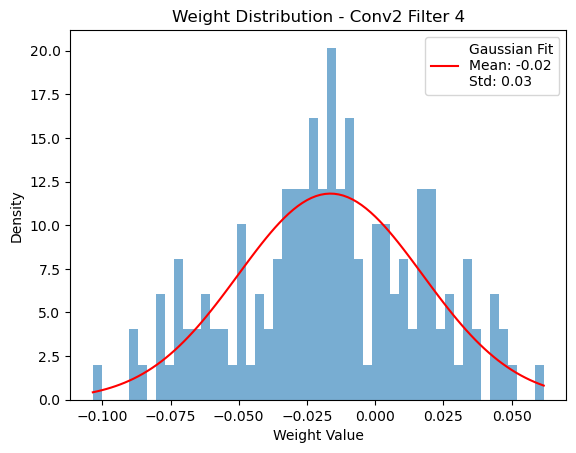

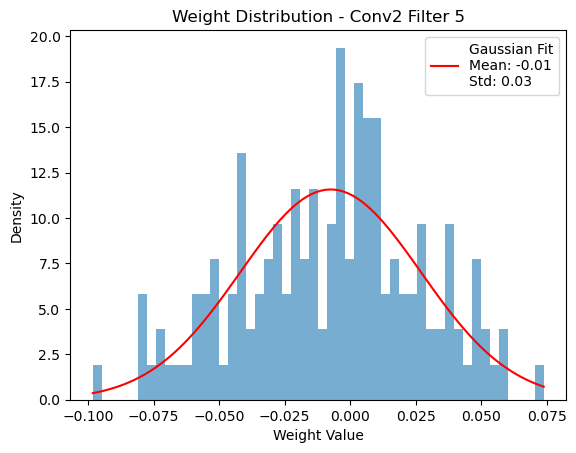

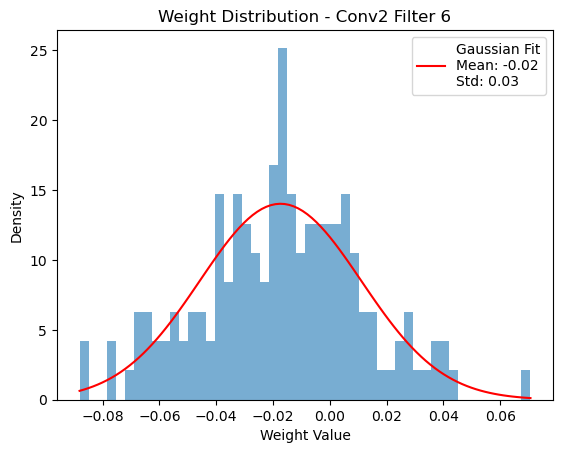

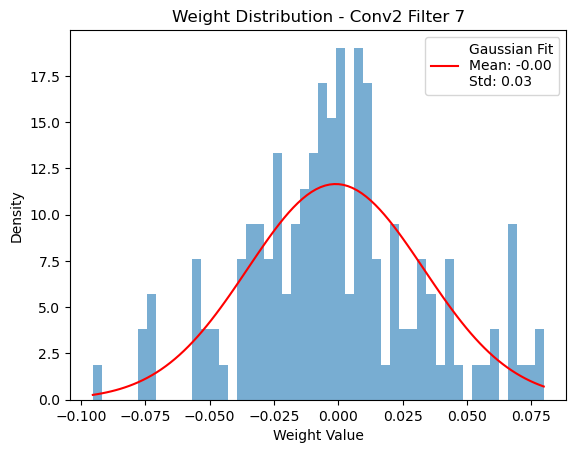

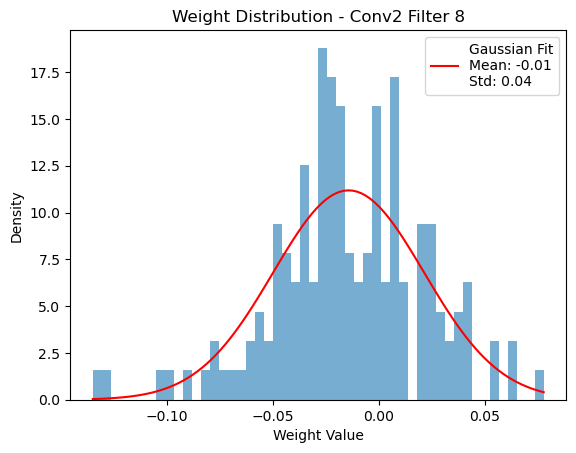

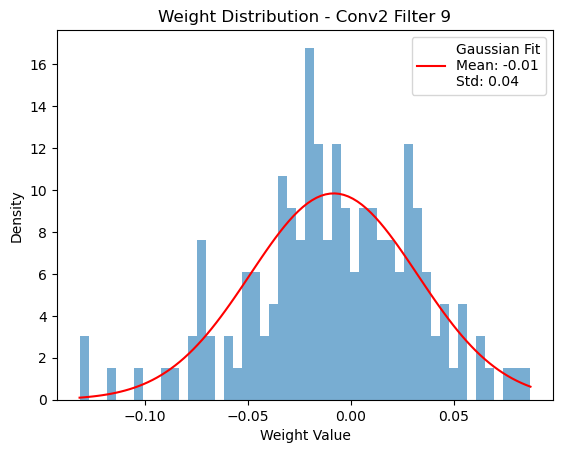

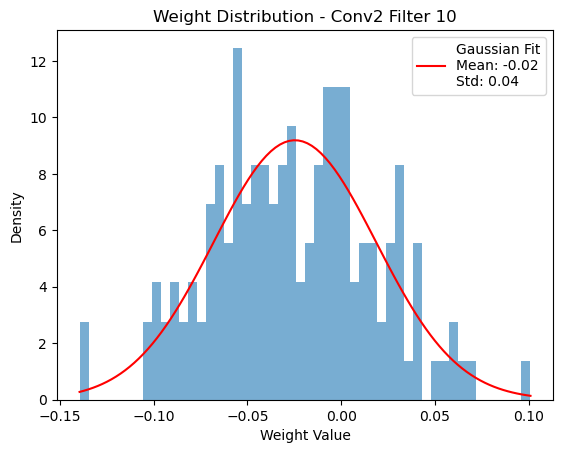

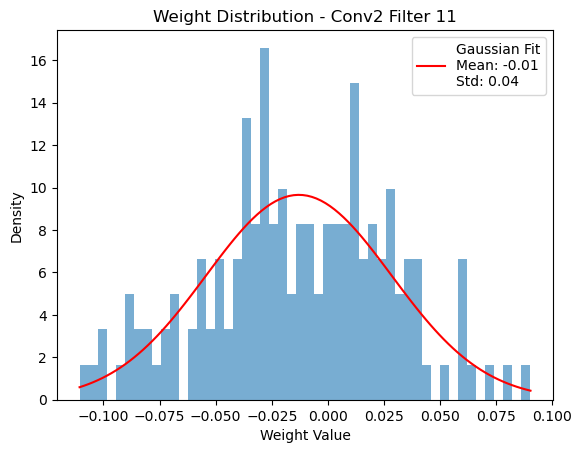

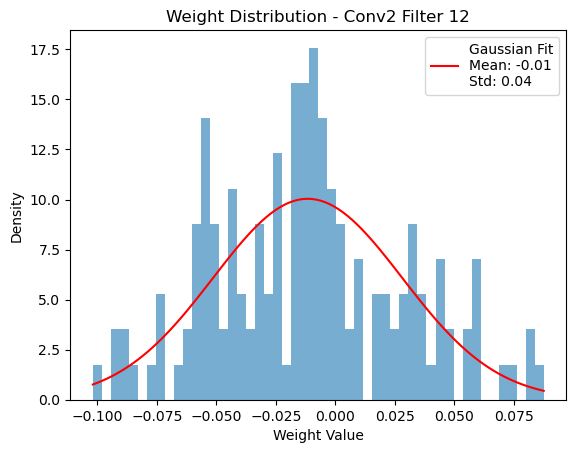

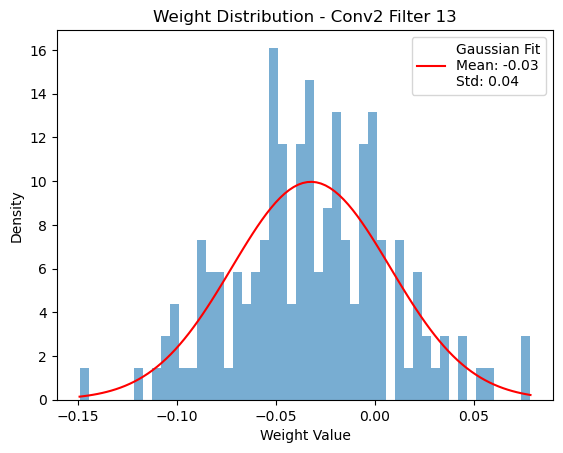

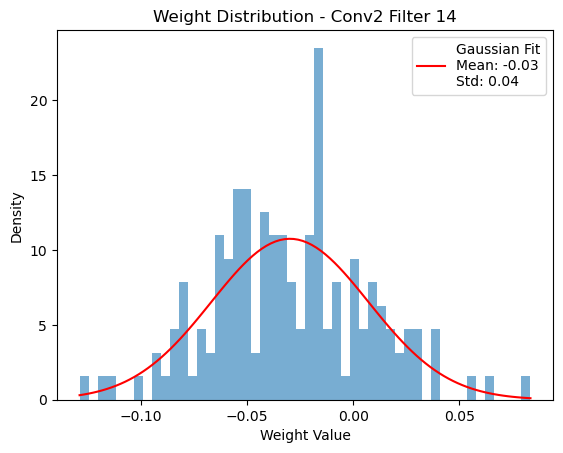

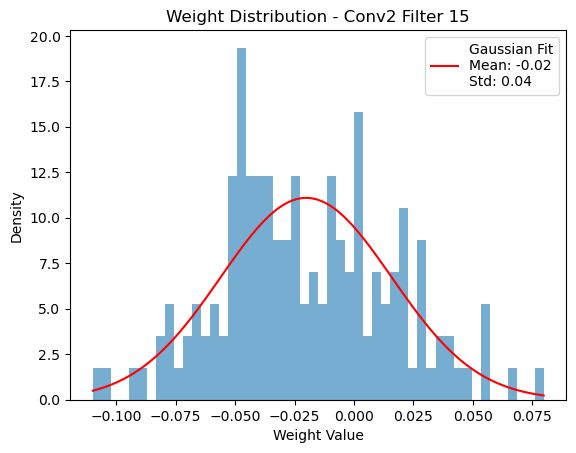

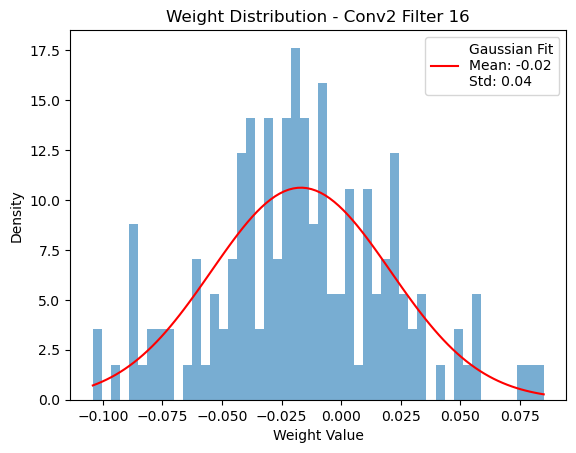

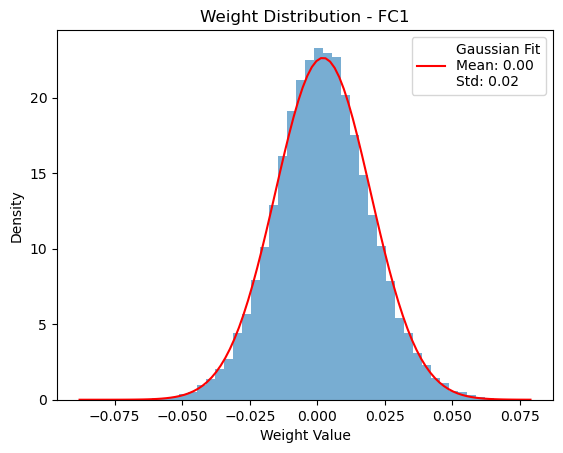

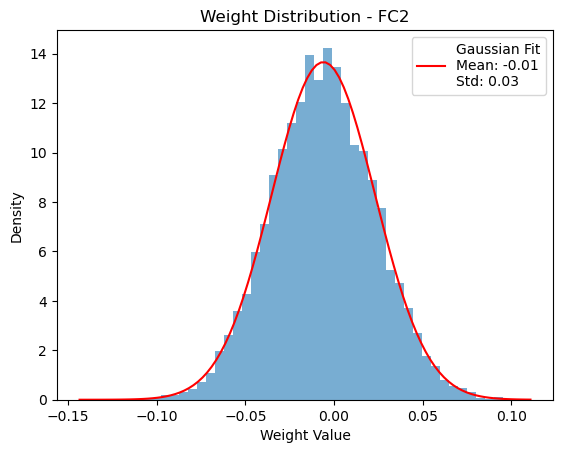

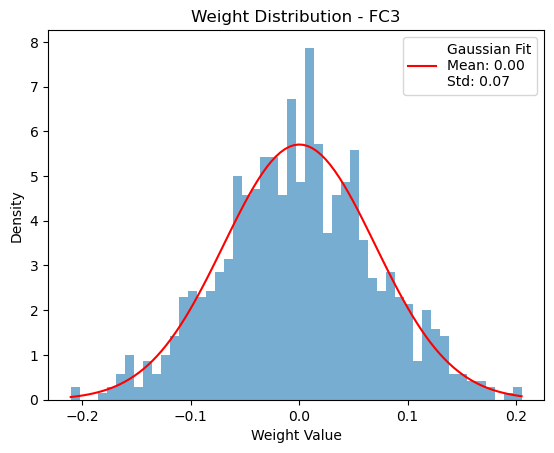

In [17]:
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scripts import (
    evaluate_model_v2,
    load_metadata,
    add_metadata,
    check_if_metadata_has_results,
    load_model,
)
from models import LeNet5

model_class = LeNet5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
folder_path = "models/saved_models"
folder_path_meta = "models/saved_models_metadata"
file_names = os.listdir(folder_path)

conv1_weights_all = []
conv2_weights_all = []
fc1_weights_all = []
fc2_weights_all = []
fc3_weights_all = []



for file_name in file_names:
    model = load_model(os.path.join(folder_path, file_name), model_class).to(device)
    uuid = find_uuid(file_name)
    target_file = f"metadata_{uuid}.json"
    metadata_path = os.path.join(folder_path_meta, target_file)
    metadata = load_metadata(metadata_path)
    accuracy = metadata["Accuracy"]
    if accuracy > 0.15:
        conv1_weights_all.append(model.conv1.weight.data.cpu().numpy())
        conv2_weights_all.append(model.conv2.weight.data.cpu().numpy())
        fc1_weights_all.append(model.fc1.weight.data.cpu().numpy())
        fc2_weights_all.append(model.fc2.weight.data.cpu().numpy())
        fc3_weights_all.append(model.fc3.weight.data.cpu().numpy())


def average_weights_across_models(weights_list):
    stacked_weights = np.stack(weights_list, axis=0)
    return np.mean(stacked_weights, axis=0)


def plot_distribution(weights, layer_name):
    mean = np.mean(weights)
    std = np.std(weights)
    x = np.linspace(np.min(weights), np.max(weights), 100)
    y = norm.pdf(x, mean, std)
    plt.hist(weights.flatten(), bins=50, density=True, alpha=0.6)
    plt.plot(x, y, "r-", label=f"Gaussian Fit\nMean: {mean:.2f}\nStd: {std:.2f}")
    plt.title(f"Weight Distribution - {layer_name}")
    plt.xlabel("Weight Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()


conv1_avg = average_weights_across_models(conv1_weights_all)
conv2_avg = average_weights_across_models(conv2_weights_all)
fc1_avg = average_weights_across_models(fc1_weights_all)
fc2_avg = average_weights_across_models(fc2_weights_all)
fc3_avg = average_weights_across_models(fc3_weights_all)

for i, filter_weights in enumerate(conv1_avg):
    plot_distribution(filter_weights, f"Conv1 Filter {i+1}")

for i, filter_weights in enumerate(conv2_avg):
    plot_distribution(filter_weights, f"Conv2 Filter {i+1}")

plot_distribution(fc1_avg, "FC1")
plot_distribution(fc2_avg, "FC2")
plot_distribution(fc3_avg, "FC3")

### Bad Models (accuracy between 0.15 and 0.5)

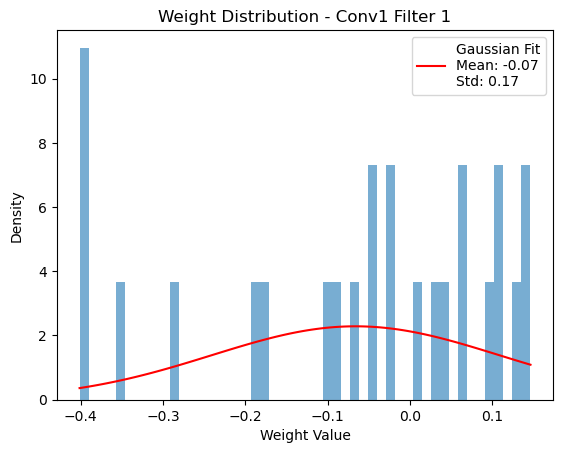

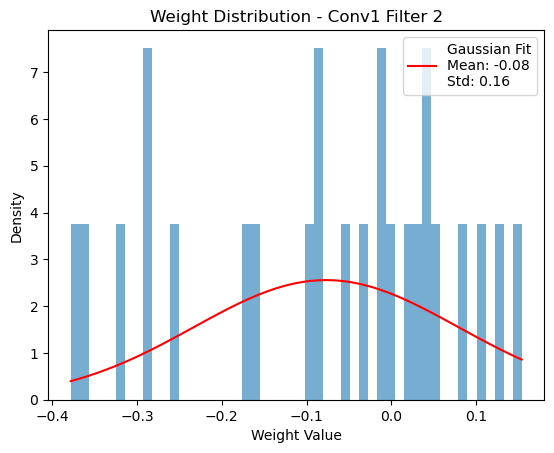

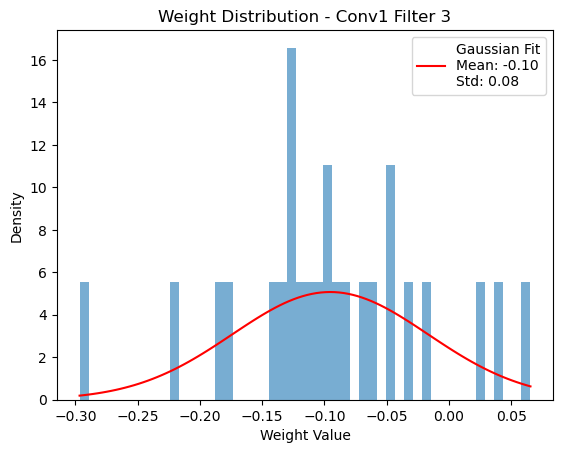

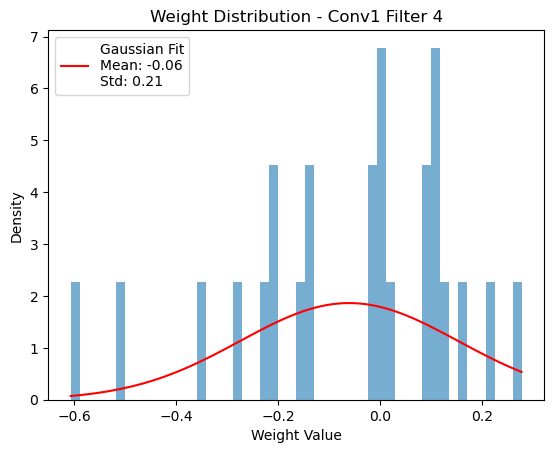

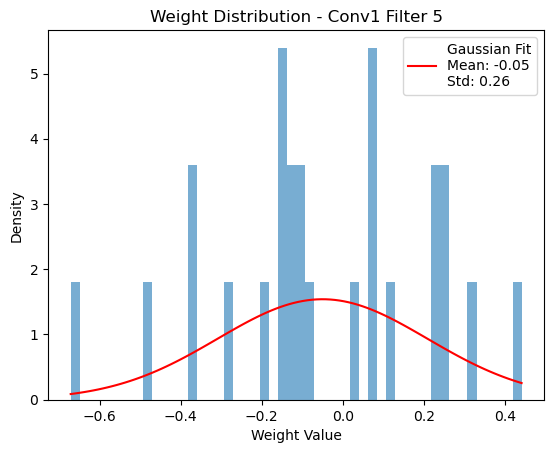

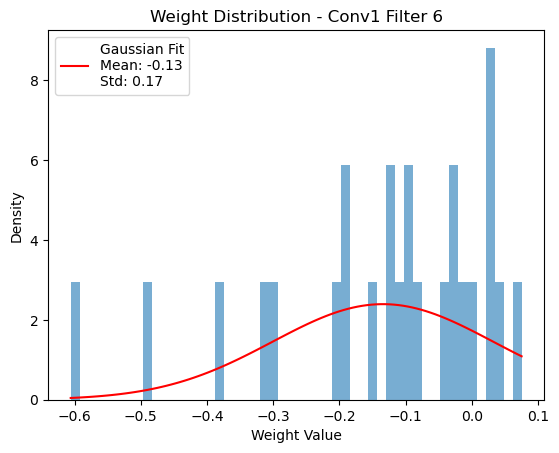

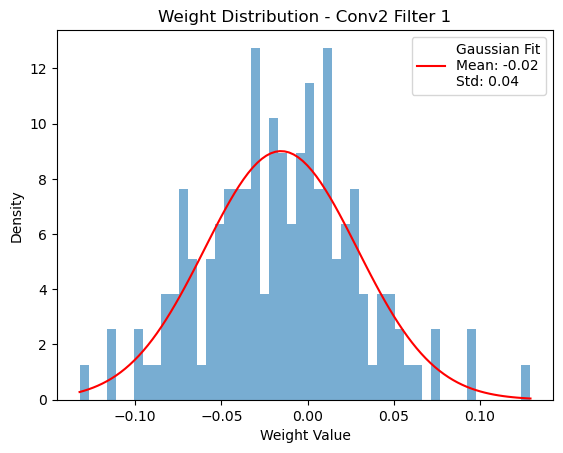

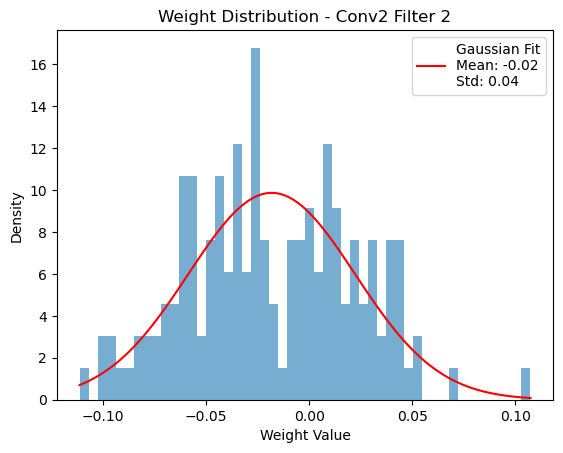

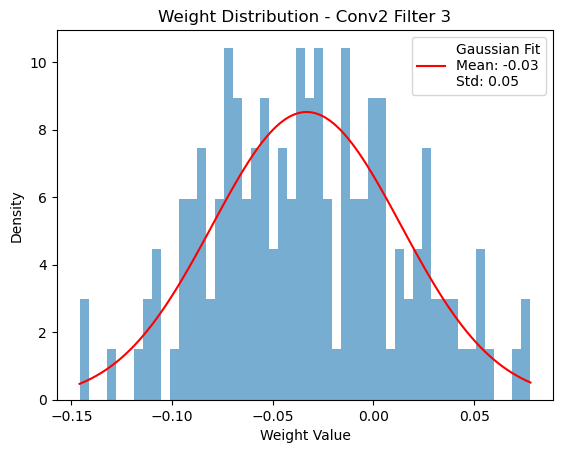

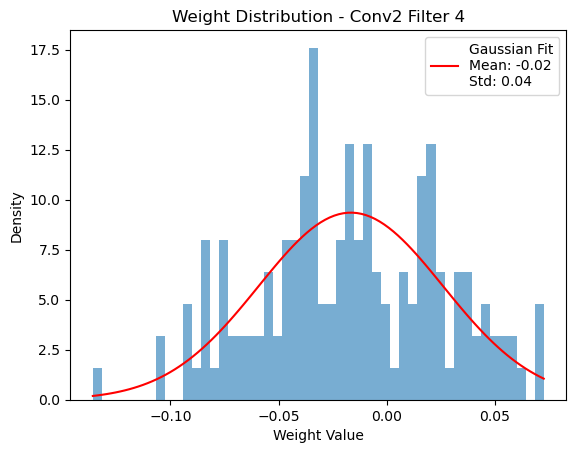

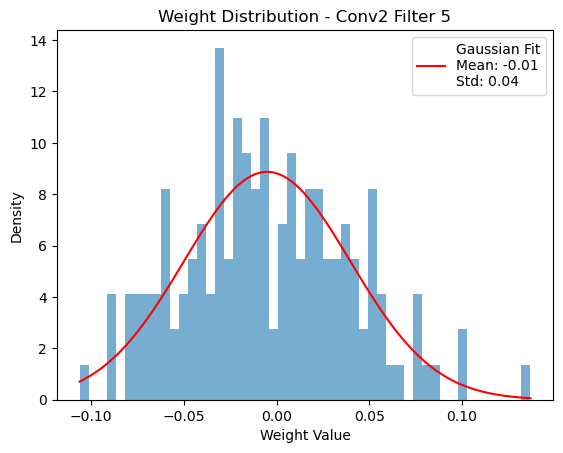

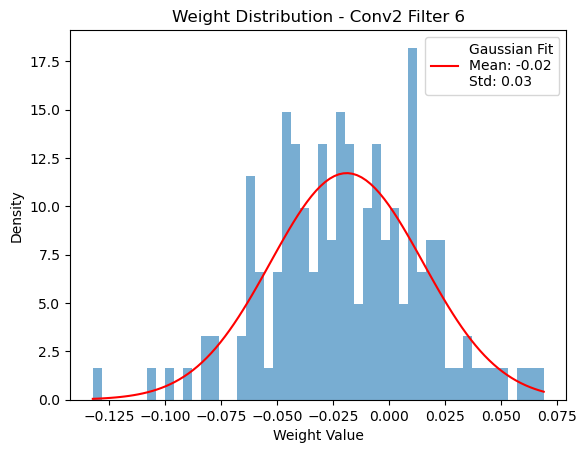

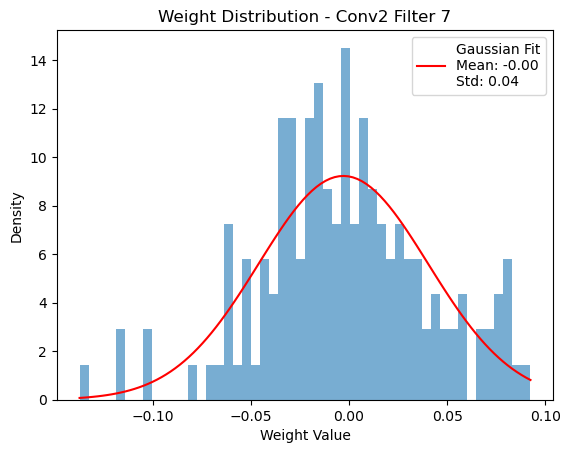

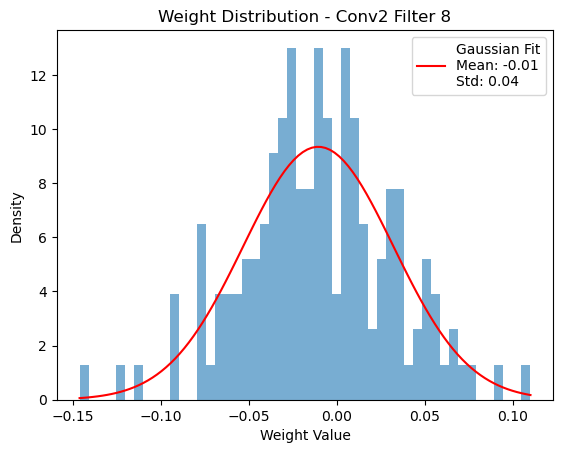

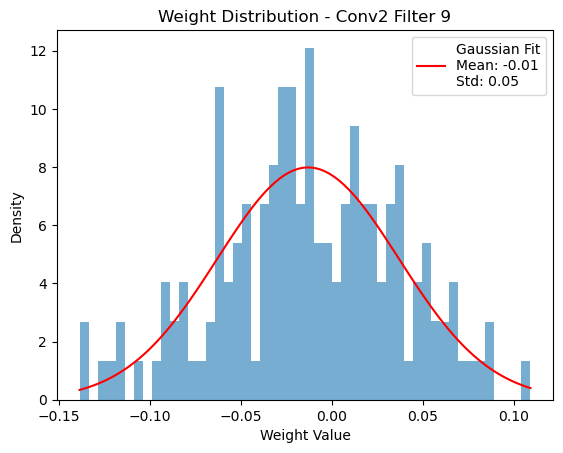

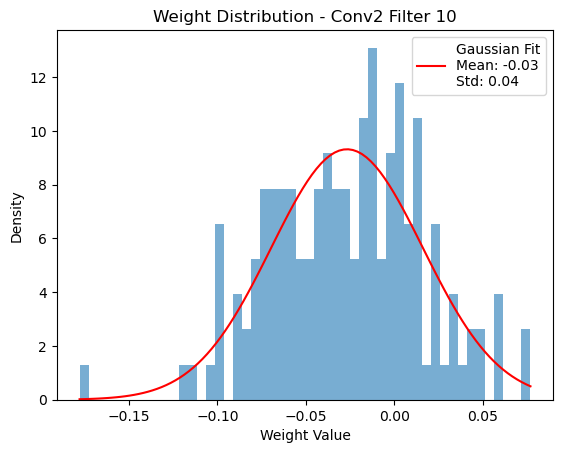

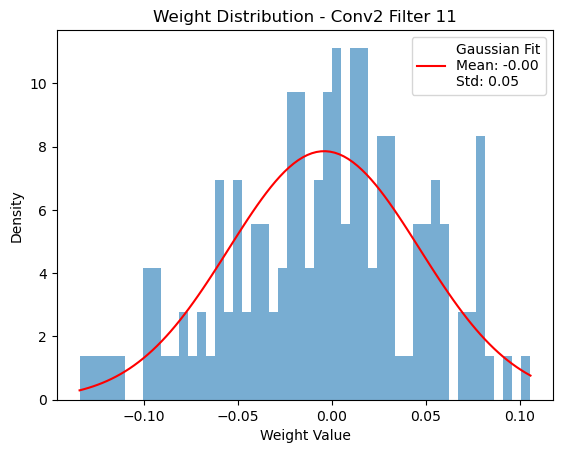

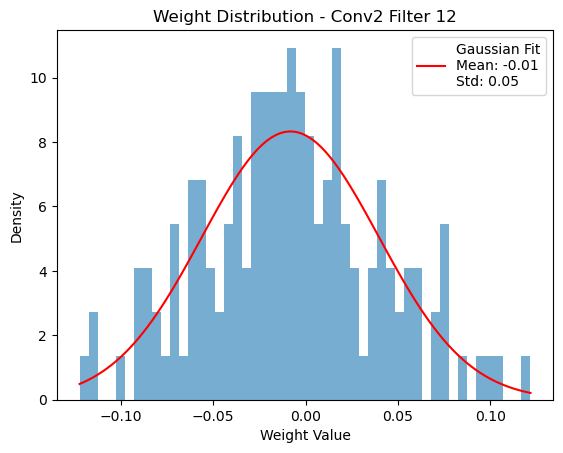

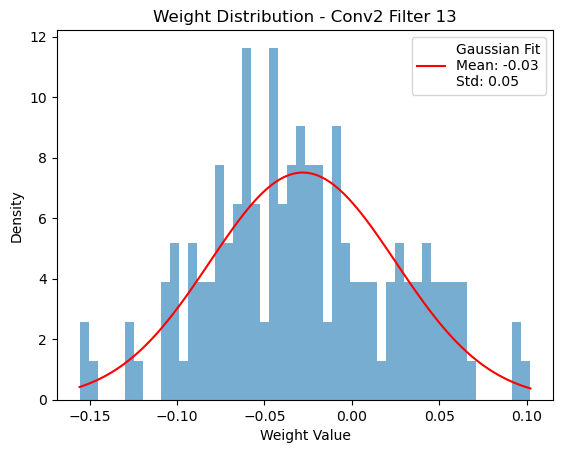

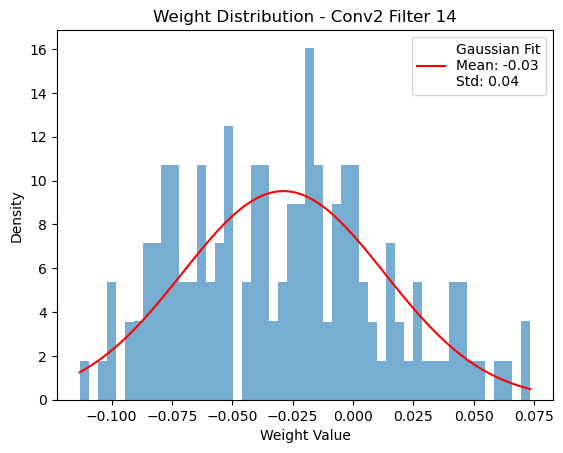

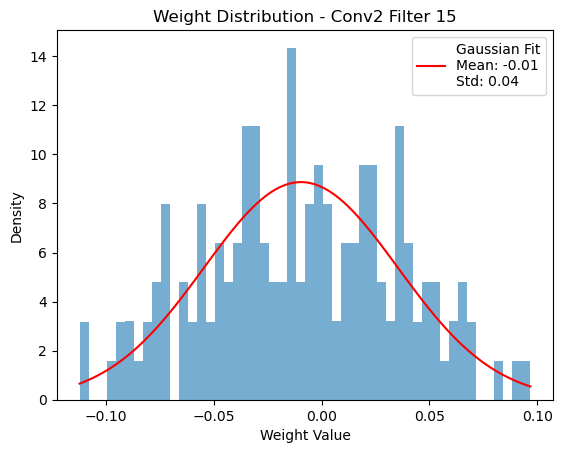

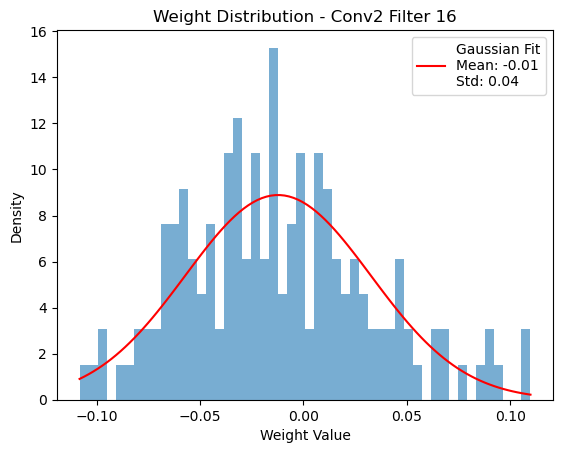

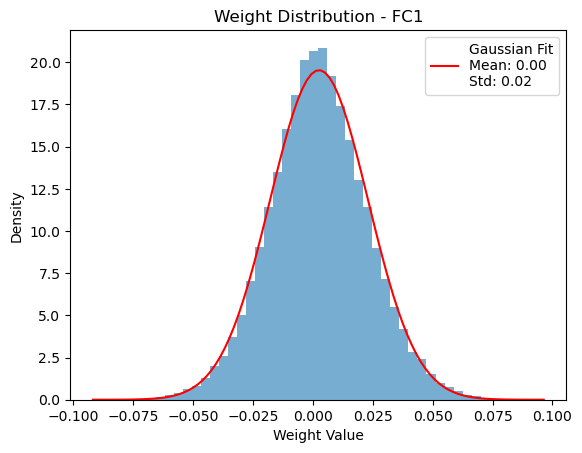

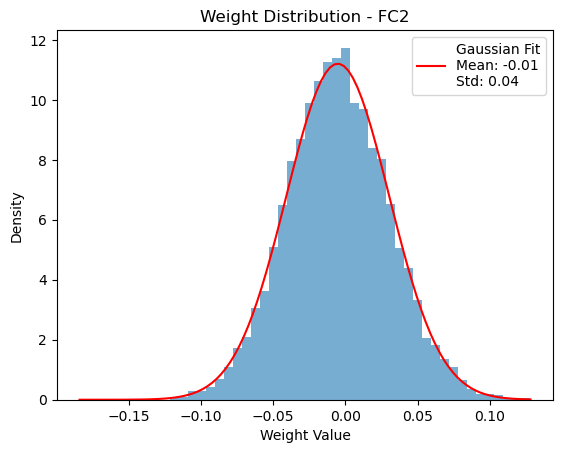

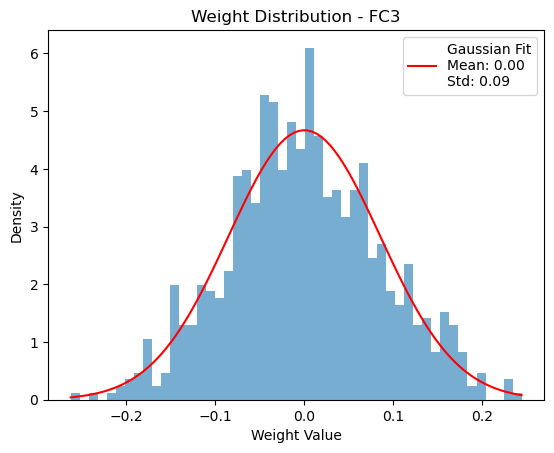

In [18]:
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scripts import (
    evaluate_model_v2,
    load_metadata,
    add_metadata,
    check_if_metadata_has_results,
    load_model,
)
from models import LeNet5

model_class = LeNet5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
folder_path = "models/saved_models"
folder_path_meta = "models/saved_models_metadata"
file_names = os.listdir(folder_path)

conv1_weights_all = []
conv2_weights_all = []
fc1_weights_all = []
fc2_weights_all = []
fc3_weights_all = []


for file_name in file_names:
    model = load_model(os.path.join(folder_path, file_name), model_class).to(device)
    uuid = find_uuid(file_name)
    target_file = f"metadata_{uuid}.json"
    metadata_path = os.path.join(folder_path_meta, target_file)
    metadata = load_metadata(metadata_path)
    accuracy = metadata["Accuracy"]
    if accuracy > 0.15 and accuracy < 0.5:
        conv1_weights_all.append(model.conv1.weight.data.cpu().numpy())
        conv2_weights_all.append(model.conv2.weight.data.cpu().numpy())
        fc1_weights_all.append(model.fc1.weight.data.cpu().numpy())
        fc2_weights_all.append(model.fc2.weight.data.cpu().numpy())
        fc3_weights_all.append(model.fc3.weight.data.cpu().numpy())


def average_weights_across_models(weights_list):
    stacked_weights = np.stack(weights_list, axis=0)
    return np.mean(stacked_weights, axis=0)


def plot_distribution(weights, layer_name):
    mean = np.mean(weights)
    std = np.std(weights)
    x = np.linspace(np.min(weights), np.max(weights), 100)
    y = norm.pdf(x, mean, std)
    plt.hist(weights.flatten(), bins=50, density=True, alpha=0.6)
    plt.plot(x, y, "r-", label=f"Gaussian Fit\nMean: {mean:.2f}\nStd: {std:.2f}")
    plt.title(f"Weight Distribution - {layer_name}")
    plt.xlabel("Weight Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()


conv1_avg = average_weights_across_models(conv1_weights_all)
conv2_avg = average_weights_across_models(conv2_weights_all)
fc1_avg = average_weights_across_models(fc1_weights_all)
fc2_avg = average_weights_across_models(fc2_weights_all)
fc3_avg = average_weights_across_models(fc3_weights_all)

for i, filter_weights in enumerate(conv1_avg):
    plot_distribution(filter_weights, f"Conv1 Filter {i+1}")

for i, filter_weights in enumerate(conv2_avg):
    plot_distribution(filter_weights, f"Conv2 Filter {i+1}")

plot_distribution(fc1_avg, "FC1")
plot_distribution(fc2_avg, "FC2")
plot_distribution(fc3_avg, "FC3")

### Good models ( accuracy above 0.9 )

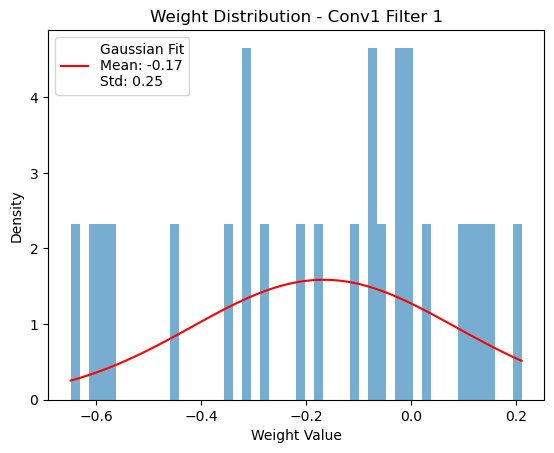

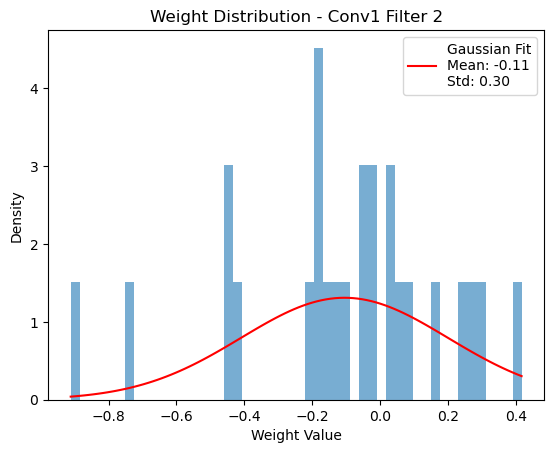

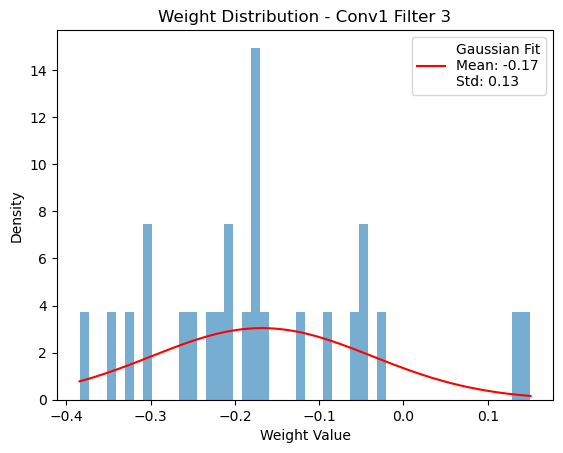

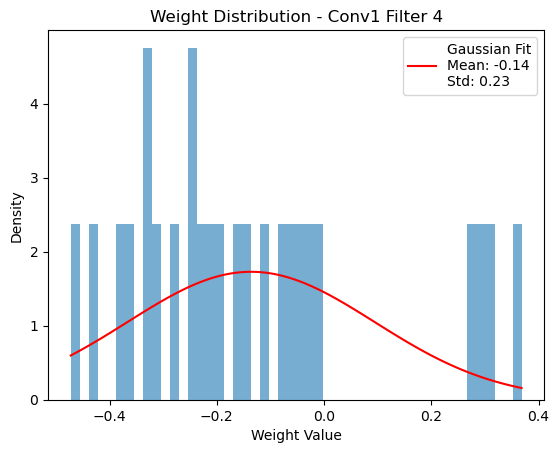

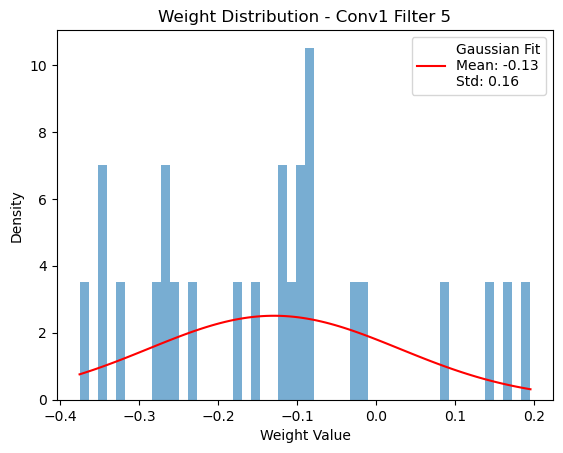

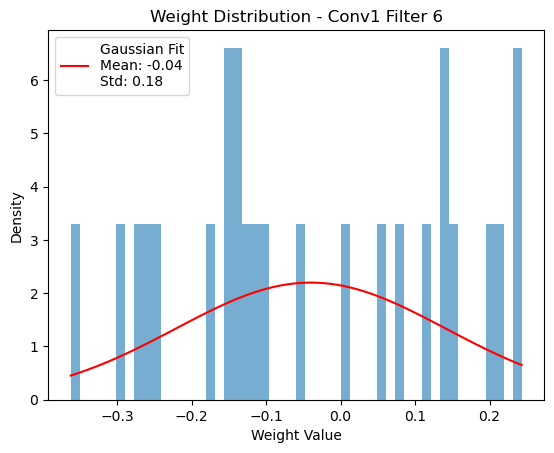

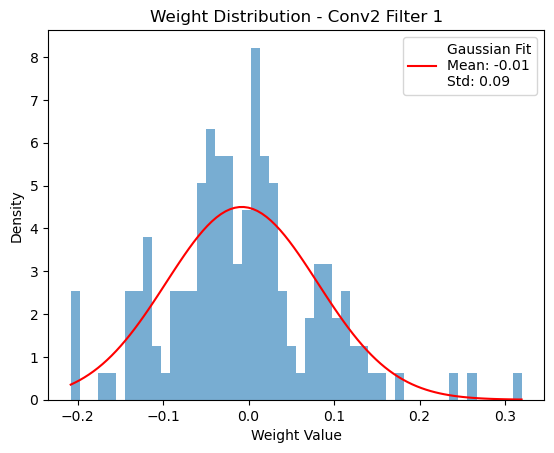

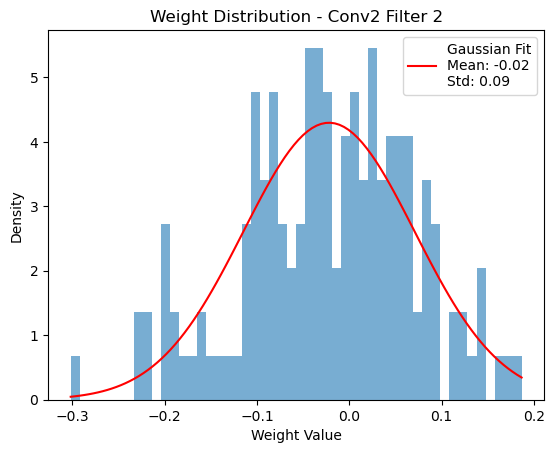

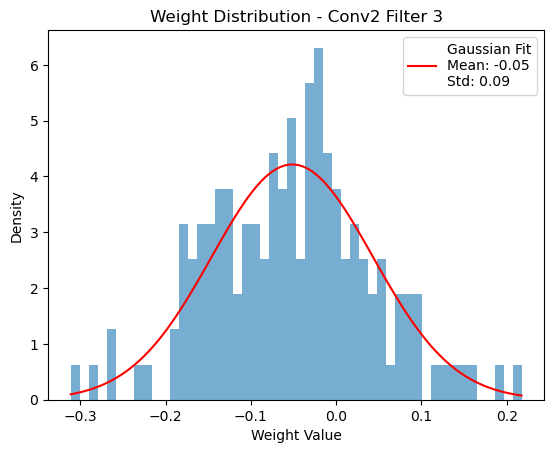

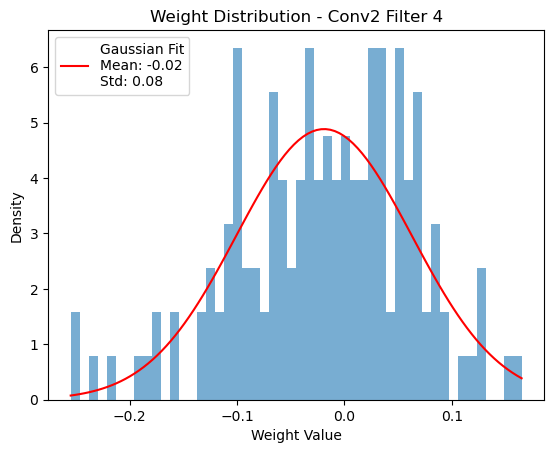

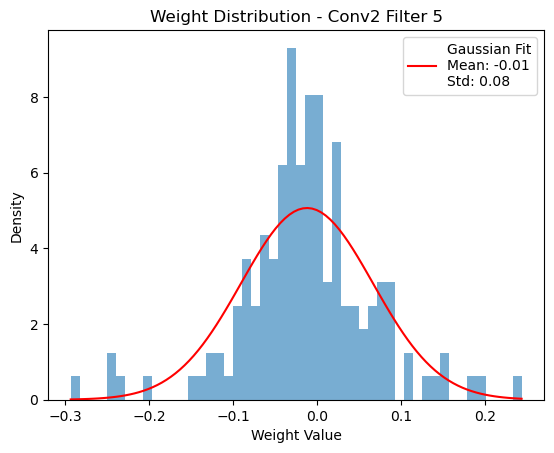

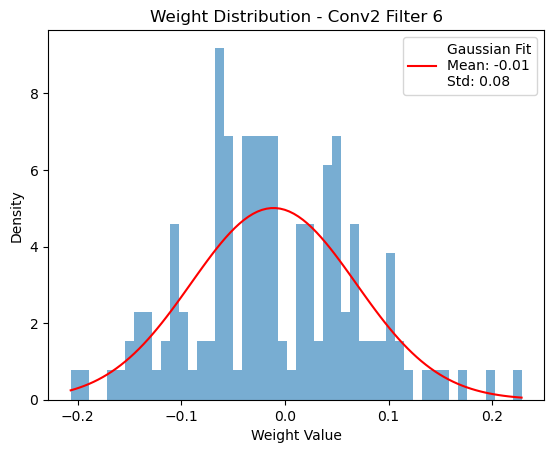

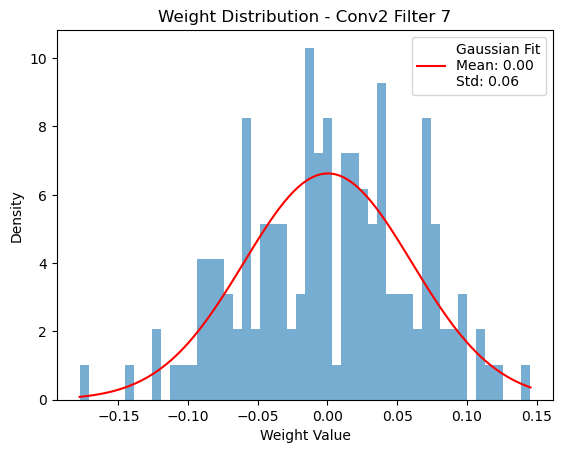

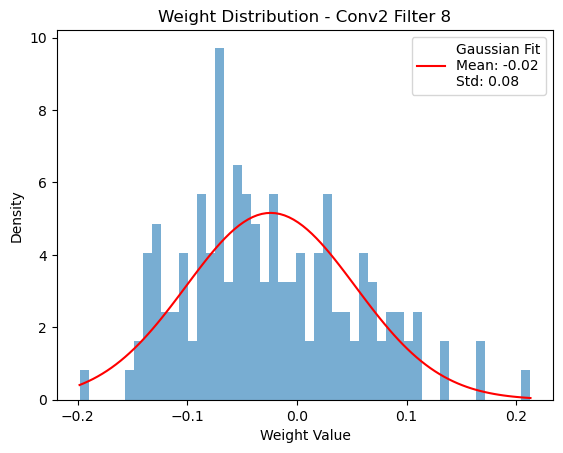

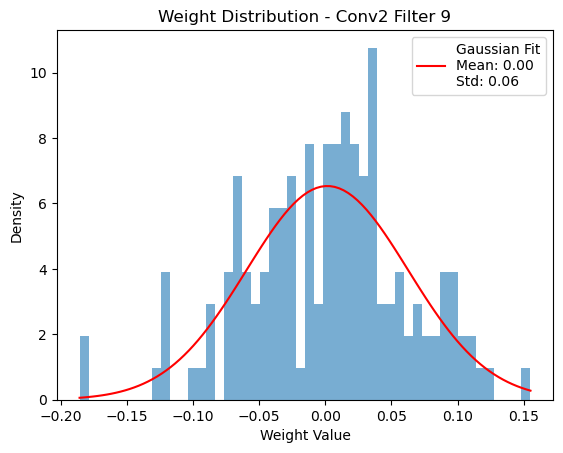

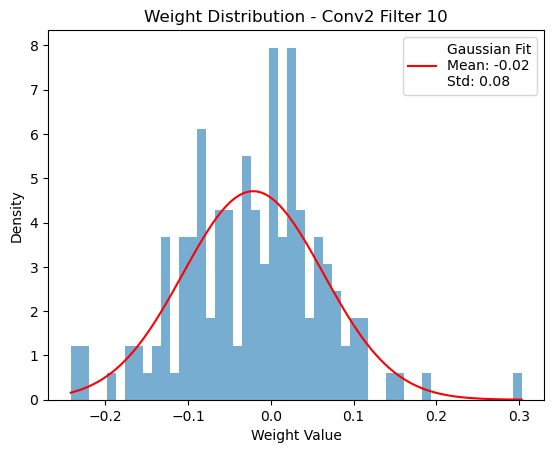

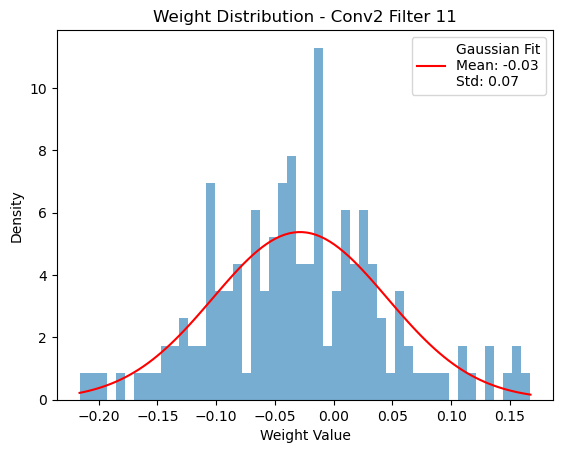

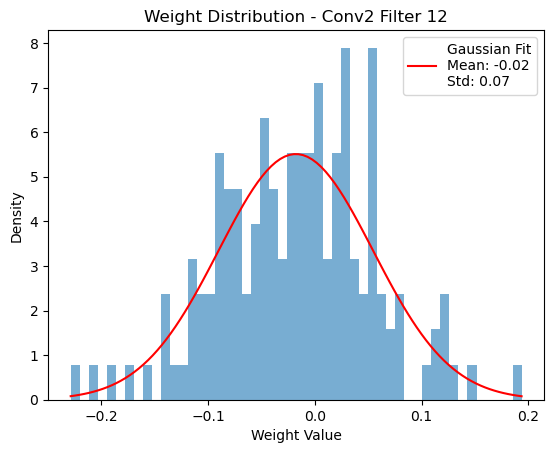

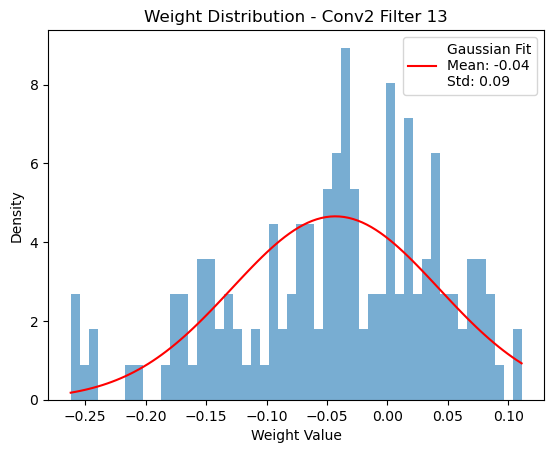

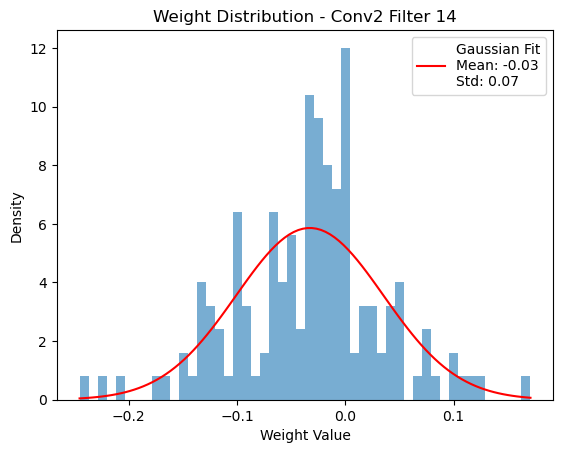

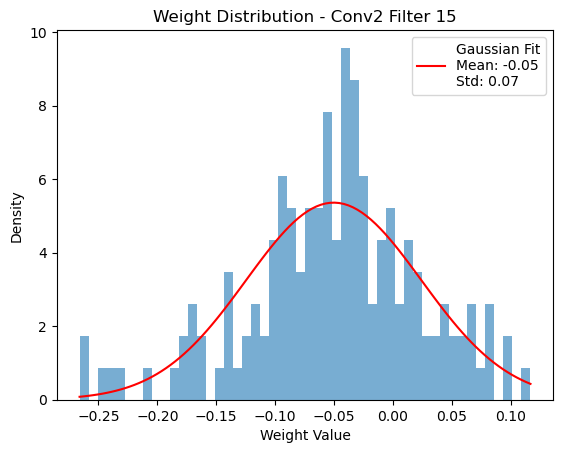

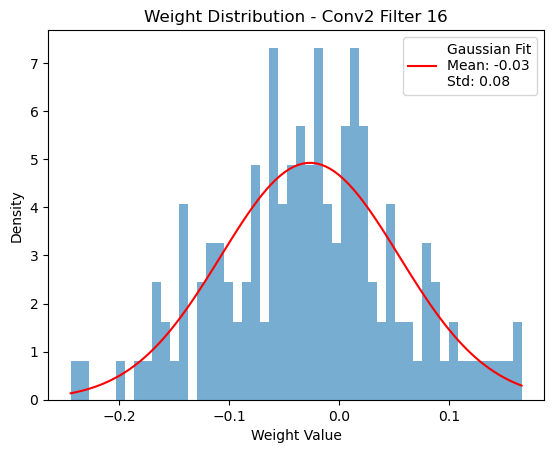

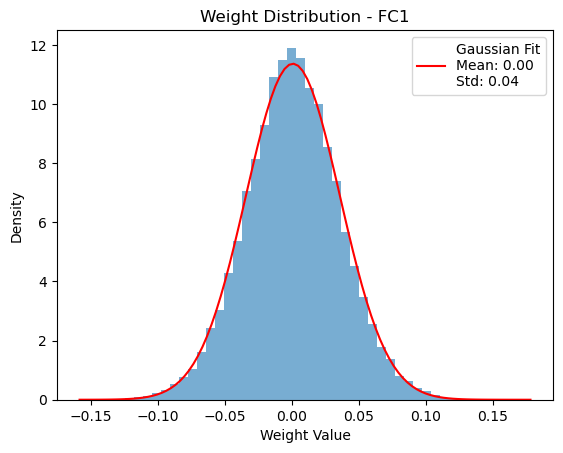

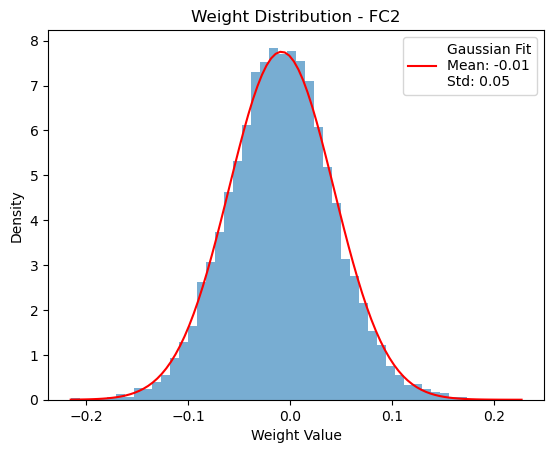

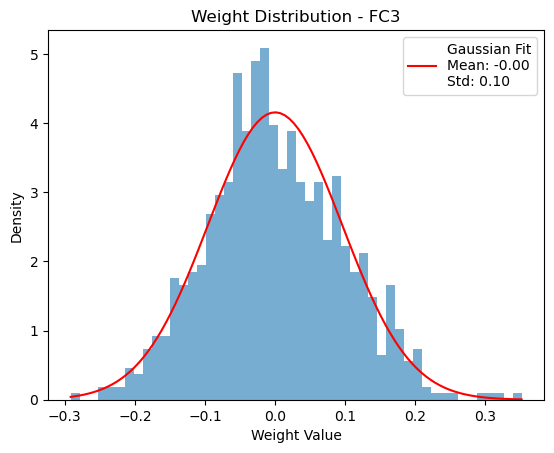

In [11]:
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scripts import (
    evaluate_model_v2,
    load_metadata,
    add_metadata,
    check_if_metadata_has_results,
    load_model,
)
from models import LeNet5

model_class = LeNet5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
folder_path = "models/saved_models"
folder_path_meta = "models/saved_models_metadata"
file_names = os.listdir(folder_path)

conv1_weights_all = []
conv2_weights_all = []
fc1_weights_all = []
fc2_weights_all = []
fc3_weights_all = []


for file_name in file_names:
    model = load_model(os.path.join(folder_path, file_name), model_class).to(device)
    uuid = find_uuid(file_name)
    target_file = f"metadata_{uuid}.json"
    metadata_path = os.path.join(folder_path_meta, target_file)
    metadata = load_metadata(metadata_path)
    accuracy = metadata["Accuracy"]
    if accuracy > 0.90:
        conv1_weights_all.append(model.conv1.weight.data.cpu().numpy())
        conv2_weights_all.append(model.conv2.weight.data.cpu().numpy())
        fc1_weights_all.append(model.fc1.weight.data.cpu().numpy())
        fc2_weights_all.append(model.fc2.weight.data.cpu().numpy())
        fc3_weights_all.append(model.fc3.weight.data.cpu().numpy())


def average_weights_across_models(weights_list):
    stacked_weights = np.stack(weights_list, axis=0)
    return np.mean(stacked_weights, axis=0)


def plot_distribution(weights, layer_name):
    mean = np.mean(weights)
    std = np.std(weights)
    x = np.linspace(np.min(weights), np.max(weights), 100)
    y = norm.pdf(x, mean, std)
    plt.hist(weights.flatten(), bins=50, density=True, alpha=0.6)
    plt.plot(x, y, "r-", label=f"Gaussian Fit\nMean: {mean:.2f}\nStd: {std:.2f}")
    plt.title(f"Weight Distribution - {layer_name}")
    plt.xlabel("Weight Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()


conv1_avg = average_weights_across_models(conv1_weights_all)
conv2_avg = average_weights_across_models(conv2_weights_all)
fc1_avg = average_weights_across_models(fc1_weights_all)
fc2_avg = average_weights_across_models(fc2_weights_all)
fc3_avg = average_weights_across_models(fc3_weights_all)

for i, filter_weights in enumerate(conv1_avg):
    plot_distribution(filter_weights, f"Conv1 Filter {i+1}")

for i, filter_weights in enumerate(conv2_avg):
    plot_distribution(filter_weights, f"Conv2 Filter {i+1}")

plot_distribution(fc1_avg, "FC1")
plot_distribution(fc2_avg, "FC2")
plot_distribution(fc3_avg, "FC3")

### Bad models ( accuracy between 0.15 and 0.5 ) | Only fully-connected layers

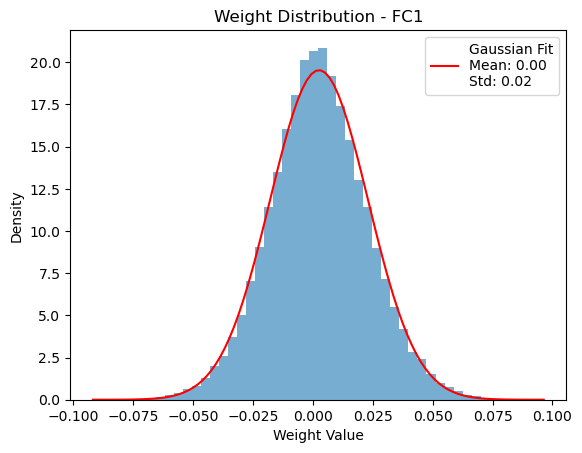

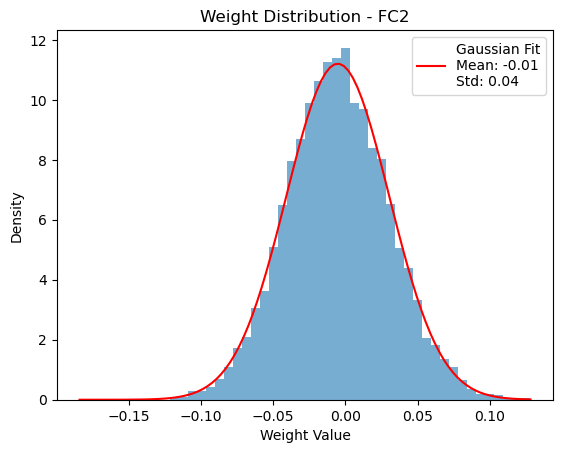

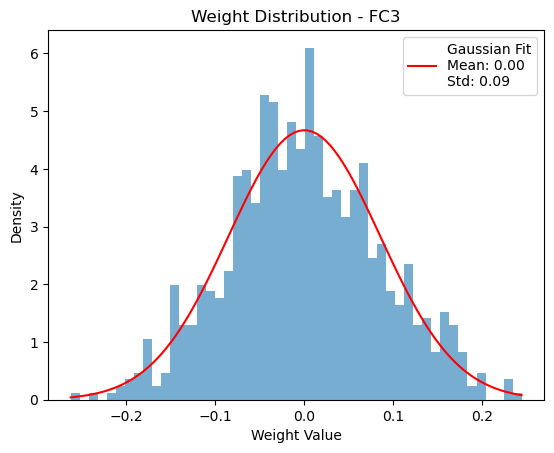

In [19]:
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scripts import (
    evaluate_model_v2,
    load_metadata,
    add_metadata,
    check_if_metadata_has_results,
    load_model,
)
from models import LeNet5

model_class = LeNet5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
folder_path = "models/saved_models"
folder_path_meta = "models/saved_models_metadata"
file_names = os.listdir(folder_path)

conv1_weights_all = []
conv2_weights_all = []
fc1_weights_all = []
fc2_weights_all = []
fc3_weights_all = []


for file_name in file_names:
    model = load_model(os.path.join(folder_path, file_name), model_class).to(device)
    uuid = find_uuid(file_name)
    target_file = f"metadata_{uuid}.json"
    metadata_path = os.path.join(folder_path_meta, target_file)
    metadata = load_metadata(metadata_path)
    accuracy = metadata["Accuracy"]
    if accuracy > 0.15 and accuracy < 0.5:
        conv1_weights_all.append(model.conv1.weight.data.cpu().numpy())
        conv2_weights_all.append(model.conv2.weight.data.cpu().numpy())
        fc1_weights_all.append(model.fc1.weight.data.cpu().numpy())
        fc2_weights_all.append(model.fc2.weight.data.cpu().numpy())
        fc3_weights_all.append(model.fc3.weight.data.cpu().numpy())


def average_weights_across_models(weights_list):
    stacked_weights = np.stack(weights_list, axis=0)
    return np.mean(stacked_weights, axis=0)


def plot_distribution(weights, layer_name):
    mean = np.mean(weights)
    std = np.std(weights)
    x = np.linspace(np.min(weights), np.max(weights), 100)
    y = norm.pdf(x, mean, std)
    plt.hist(weights.flatten(), bins=50, density=True, alpha=0.6)
    plt.plot(x, y, "r-", label=f"Gaussian Fit\nMean: {mean:.2f}\nStd: {std:.2f}")
    plt.title(f"Weight Distribution - {layer_name}")
    plt.xlabel("Weight Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()


conv1_avg = average_weights_across_models(conv1_weights_all)
conv2_avg = average_weights_across_models(conv2_weights_all)
fc1_avg = average_weights_across_models(fc1_weights_all)
fc2_avg = average_weights_across_models(fc2_weights_all)
fc3_avg = average_weights_across_models(fc3_weights_all)

# for i, filter_weights in enumerate(conv1_avg):
#     plot_distribution(filter_weights, f"Conv1 Filter {i+1}")

# for i, filter_weights in enumerate(conv2_avg):
#     plot_distribution(filter_weights, f"Conv2 Filter {i+1}")

plot_distribution(fc1_avg, "FC1")
plot_distribution(fc2_avg, "FC2")
plot_distribution(fc3_avg, "FC3")

### Good models ( accuracy > 0.9 ) | Only fully-connected layers

c:\Users\cypri\OneDrive - CentraleSupelec\Bureau\Non_Linear_Systems\scripts\utils.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model

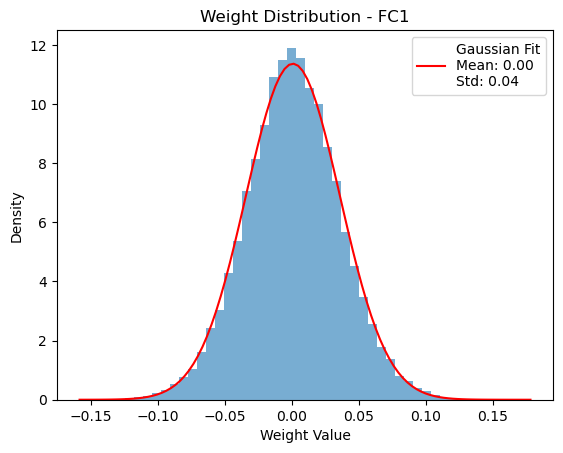

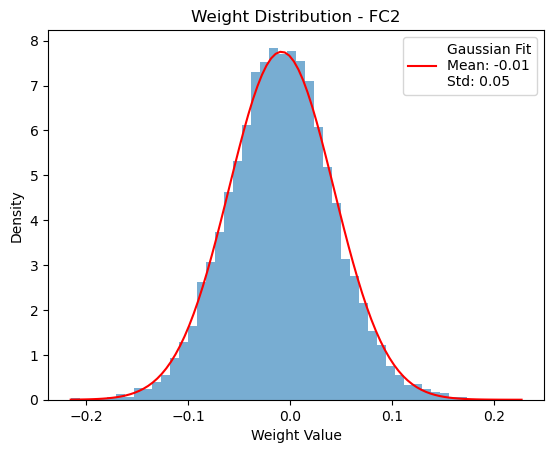

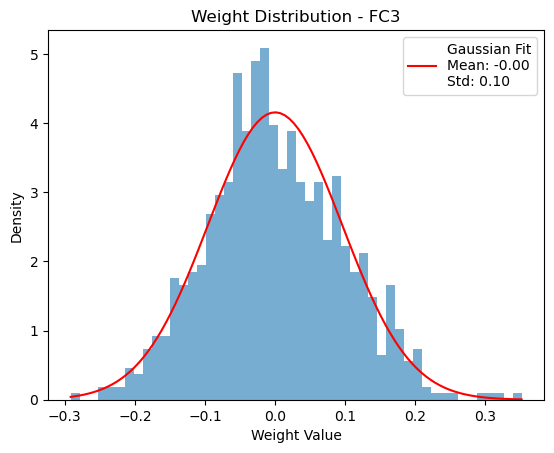

In [14]:
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scripts import (
    evaluate_model_v2,
    load_metadata,
    add_metadata,
    check_if_metadata_has_results,
    load_model,
)
from models import LeNet5

model_class = LeNet5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
folder_path = "models/saved_models"
folder_path_meta = "models/saved_models_metadata"
file_names = os.listdir(folder_path)

conv1_weights_all = []
conv2_weights_all = []
fc1_weights_all = []
fc2_weights_all = []
fc3_weights_all = []


for file_name in file_names:
    model = load_model(os.path.join(folder_path, file_name), model_class).to(device)
    uuid = find_uuid(file_name)
    target_file = f"metadata_{uuid}.json"
    metadata_path = os.path.join(folder_path_meta, target_file)
    metadata = load_metadata(metadata_path)
    accuracy = metadata["Accuracy"]
    if accuracy > 0.90:
        conv1_weights_all.append(model.conv1.weight.data.cpu().numpy())
        conv2_weights_all.append(model.conv2.weight.data.cpu().numpy())
        fc1_weights_all.append(model.fc1.weight.data.cpu().numpy())
        fc2_weights_all.append(model.fc2.weight.data.cpu().numpy())
        fc3_weights_all.append(model.fc3.weight.data.cpu().numpy())


def average_weights_across_models(weights_list):
    stacked_weights = np.stack(weights_list, axis=0)
    return np.mean(stacked_weights, axis=0)


def plot_distribution(weights, layer_name):
    mean = np.mean(weights)
    std = np.std(weights)
    x = np.linspace(np.min(weights), np.max(weights), 100)
    y = norm.pdf(x, mean, std)
    plt.hist(weights.flatten(), bins=50, density=True, alpha=0.6)
    plt.plot(x, y, "r-", label=f"Gaussian Fit\nMean: {mean:.2f}\nStd: {std:.2f}")
    plt.title(f"Weight Distribution - {layer_name}")
    plt.xlabel("Weight Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()


conv1_avg = average_weights_across_models(conv1_weights_all)
conv2_avg = average_weights_across_models(conv2_weights_all)
fc1_avg = average_weights_across_models(fc1_weights_all)
fc2_avg = average_weights_across_models(fc2_weights_all)
fc3_avg = average_weights_across_models(fc3_weights_all)

# for i, filter_weights in enumerate(conv1_avg):
#     plot_distribution(filter_weights, f"Conv1 Filter {i+1}")

# for i, filter_weights in enumerate(conv2_avg):
#     plot_distribution(filter_weights, f"Conv2 Filter {i+1}")

plot_distribution(fc1_avg, "FC1")
plot_distribution(fc2_avg, "FC2")
plot_distribution(fc3_avg, "FC3")

### Only the distribution of one model here , ( compteur = 1 ) => stop

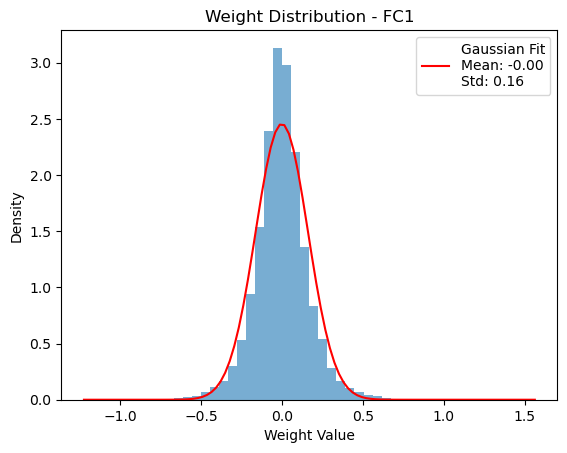

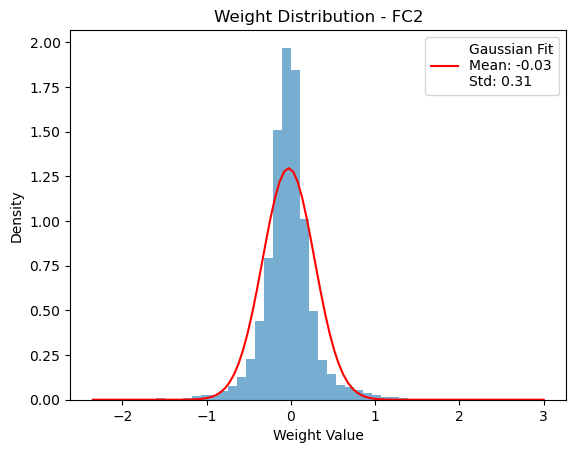

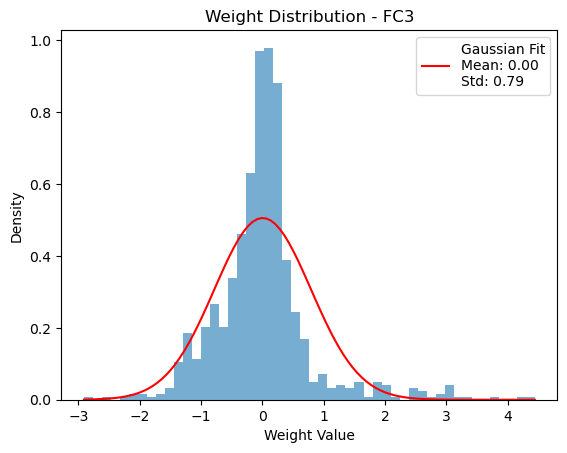

In [20]:
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scripts import (
    evaluate_model_v2,
    load_metadata,
    add_metadata,
    check_if_metadata_has_results,
    load_model,
)
from models import LeNet5

model_class = LeNet5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
folder_path = "models/saved_models"
folder_path_meta = "models/saved_models_metadata"
file_names = os.listdir(folder_path)

conv1_weights_all = []
conv2_weights_all = []
fc1_weights_all = []
fc2_weights_all = []
fc3_weights_all = []
compteur = 0 

for file_name in file_names:
    model = load_model(os.path.join(folder_path, file_name), model_class).to(device)
    uuid = find_uuid(file_name)
    target_file = f"metadata_{uuid}.json"
    metadata_path = os.path.join(folder_path_meta, target_file)
    metadata = load_metadata(metadata_path)
    accuracy = metadata["Accuracy"]
    if accuracy > 0.15 and accuracy < 0.5:
        compteur += 1
        conv1_weights_all.append(model.conv1.weight.data.cpu().numpy())
        conv2_weights_all.append(model.conv2.weight.data.cpu().numpy())
        fc1_weights_all.append(model.fc1.weight.data.cpu().numpy())
        fc2_weights_all.append(model.fc2.weight.data.cpu().numpy())
        fc3_weights_all.append(model.fc3.weight.data.cpu().numpy())
        if compteur == 1:
            break

def average_weights_across_models(weights_list):
    stacked_weights = np.stack(weights_list, axis=0)
    return np.mean(stacked_weights, axis=0)


def plot_distribution(weights, layer_name):
    mean = np.mean(weights)
    std = np.std(weights)
    x = np.linspace(np.min(weights), np.max(weights), 100)
    y = norm.pdf(x, mean, std)
    plt.hist(weights.flatten(), bins=50, density=True, alpha=0.6)
    plt.plot(x, y, "r-", label=f"Gaussian Fit\nMean: {mean:.2f}\nStd: {std:.2f}")
    plt.title(f"Weight Distribution - {layer_name}")
    plt.xlabel("Weight Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()


conv1_avg = average_weights_across_models(conv1_weights_all)
conv2_avg = average_weights_across_models(conv2_weights_all)
fc1_avg = average_weights_across_models(fc1_weights_all)
fc2_avg = average_weights_across_models(fc2_weights_all)
fc3_avg = average_weights_across_models(fc3_weights_all)

# for i, filter_weights in enumerate(conv1_avg):
#     plot_distribution(filter_weights, f"Conv1 Filter {i+1}")

# for i, filter_weights in enumerate(conv2_avg):
#     plot_distribution(filter_weights, f"Conv2 Filter {i+1}")

plot_distribution(fc1_avg, "FC1")
plot_distribution(fc2_avg, "FC2")
plot_distribution(fc3_avg, "FC3")

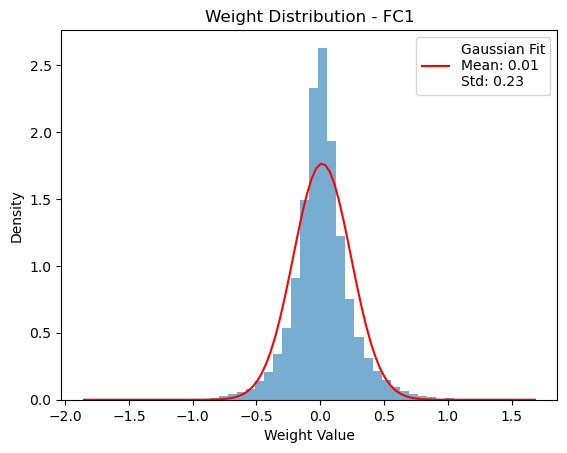

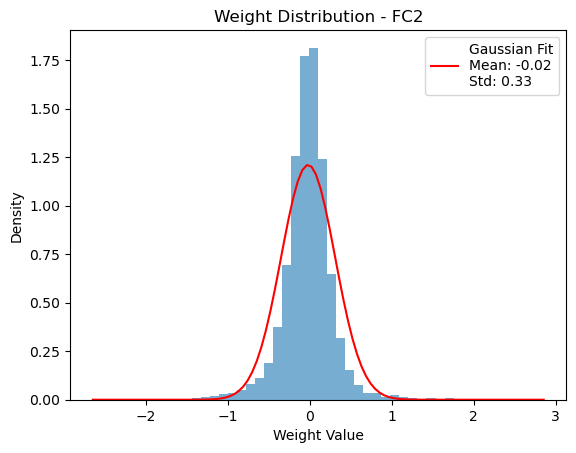

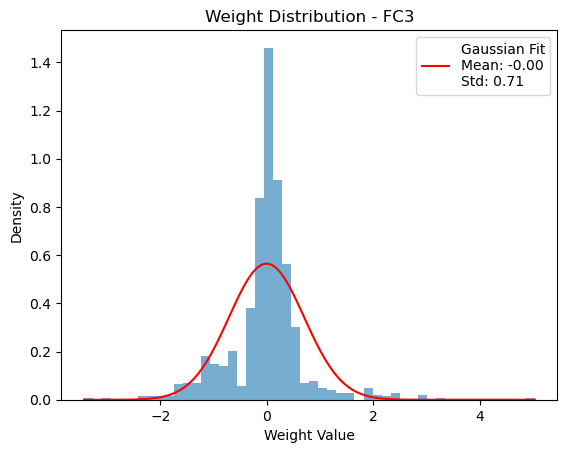

In [21]:
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scripts import (
    evaluate_model_v2,
    load_metadata,
    add_metadata,
    check_if_metadata_has_results,
    load_model,
)
from models import LeNet5

model_class = LeNet5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
folder_path = "models/saved_models"
folder_path_meta = "models/saved_models_metadata"
file_names = os.listdir(folder_path)

conv1_weights_all = []
conv2_weights_all = []
fc1_weights_all = []
fc2_weights_all = []
fc3_weights_all = []
compteur = 0

for file_name in file_names:
    model = load_model(os.path.join(folder_path, file_name), model_class).to(device)
    uuid = find_uuid(file_name)
    target_file = f"metadata_{uuid}.json"
    metadata_path = os.path.join(folder_path_meta, target_file)
    metadata = load_metadata(metadata_path)
    accuracy = metadata["Accuracy"]
    if accuracy > 0.90:
        compteur += 1
        conv1_weights_all.append(model.conv1.weight.data.cpu().numpy())
        conv2_weights_all.append(model.conv2.weight.data.cpu().numpy())
        fc1_weights_all.append(model.fc1.weight.data.cpu().numpy())
        fc2_weights_all.append(model.fc2.weight.data.cpu().numpy())
        fc3_weights_all.append(model.fc3.weight.data.cpu().numpy())
        if compteur == 1:
            break


def average_weights_across_models(weights_list):
    stacked_weights = np.stack(weights_list, axis=0)
    return np.mean(stacked_weights, axis=0)


def plot_distribution(weights, layer_name):
    mean = np.mean(weights)
    std = np.std(weights)
    x = np.linspace(np.min(weights), np.max(weights), 100)
    y = norm.pdf(x, mean, std)
    plt.hist(weights.flatten(), bins=50, density=True, alpha=0.6)
    plt.plot(x, y, "r-", label=f"Gaussian Fit\nMean: {mean:.2f}\nStd: {std:.2f}")
    plt.title(f"Weight Distribution - {layer_name}")
    plt.xlabel("Weight Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()


conv1_avg = average_weights_across_models(conv1_weights_all)
conv2_avg = average_weights_across_models(conv2_weights_all)
fc1_avg = average_weights_across_models(fc1_weights_all)
fc2_avg = average_weights_across_models(fc2_weights_all)
fc3_avg = average_weights_across_models(fc3_weights_all)

# for i, filter_weights in enumerate(conv1_avg):
#     plot_distribution(filter_weights, f"Conv1 Filter {i+1}")

# for i, filter_weights in enumerate(conv2_avg):
#     plot_distribution(filter_weights, f"Conv2 Filter {i+1}")

plot_distribution(fc1_avg, "FC1")
plot_distribution(fc2_avg, "FC2")
plot_distribution(fc3_avg, "FC3")

# Average std and mse


In [27]:
import os
import torch
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
from scripts import load_metadata, load_model
from models import LeNet5

# Model and device setup
model_class = LeNet5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
folder_path = "models/saved_models"
folder_path_meta = "models/saved_models_metadata"
file_names = os.listdir(folder_path)

# Lists to store weights
fc1_weights_all = []
fc2_weights_all = []
fc3_weights_all = []

# Filter and collect weights from "bad" models (accuracy between 0.15 and 0.5)
for file_name in file_names:
    model = load_model(os.path.join(folder_path, file_name), model_class).to(device)

    # Extract metadata
    uuid = file_name.split("_")[-1].split(".")[0]  # Extract UUID from filename
    target_file = f"metadata_{uuid}.json"
    metadata_path = os.path.join(folder_path_meta, target_file)
    metadata = load_metadata(metadata_path)

    accuracy = metadata["Accuracy"]

    if 0.15 < accuracy < 0.5:
        # Store weights
        fc1_weights_all.append(model.fc1.weight.data.cpu().numpy().flatten())
        fc2_weights_all.append(model.fc2.weight.data.cpu().numpy().flatten())
        fc3_weights_all.append(model.fc3.weight.data.cpu().numpy().flatten())


# Compute average standard deviation and standard deviation of standard deviation
def compute_std_and_std_of_std(weights_list):
    stacked_weights = np.stack(weights_list, axis=0)
    stds = np.std(
        stacked_weights, axis=0
    )  # Compute standard deviation for each weight across models
    mean_std = np.mean(stds)  # Average standard deviation
    std_of_std = np.std(stds)  # Standard deviation of standard deviation
    return mean_std, std_of_std


fc1_std_avg, fc1_std_of_std = compute_std_and_std_of_std(fc1_weights_all)
fc2_std_avg, fc2_std_of_std = compute_std_and_std_of_std(fc2_weights_all)
fc3_std_avg, fc3_std_of_std = compute_std_and_std_of_std(fc3_weights_all)


# Compute average MSE for Gaussian fit
def compute_average_mse(weights_list):
    mse_list = []
    for weights in weights_list:
        mean = np.mean(weights)
        std = np.std(weights)
        hist, bin_edges = np.histogram(weights, bins=50, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Get bin centers for MSE
        gaussian_fit = norm.pdf(bin_centers, mean, std)
        mse = mean_squared_error(hist, gaussian_fit)
        mse_list.append(mse)
    return np.mean(mse_list)


fc1_mse_avg = compute_average_mse(fc1_weights_all)
fc2_mse_avg = compute_average_mse(fc2_weights_all)
fc3_mse_avg = compute_average_mse(fc3_weights_all)

# Output results
results = {
    "fc1_avg_std": fc1_std_avg,
    "fc2_avg_std": fc2_std_avg,
    "fc3_avg_std": fc3_std_avg,
    "fc1_std_of_std": fc1_std_of_std,
    "fc2_std_of_std": fc2_std_of_std,
    "fc3_std_of_std": fc3_std_of_std,
    "fc1_avg_mse": fc1_mse_avg,
    "fc2_avg_mse": fc2_mse_avg,
    "fc3_avg_mse": fc3_mse_avg,
}

# Convert to DataFrame and print results
df_results = pd.DataFrame([results])
print(df_results)

c:\Users\cypri\OneDrive - CentraleSupelec\Bureau\Non_Linear_Systems\scripts\utils.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model

   fc1_avg_std  fc2_avg_std  fc3_avg_std  fc1_std_of_std  fc2_std_of_std  \
0     0.196514     0.344928     0.745484        0.041174        0.072144   

   fc3_std_of_std  fc1_avg_mse  fc2_avg_mse  fc3_avg_mse  
0        0.164099     0.035244     0.018776     0.015512  


In [26]:
import os
from scripts import load_metadata


folder_path_meta = "models/saved_models_metadata"
file_names = os.listdir(folder_path_meta)


count_015_to_05 = 0
count_above_09 = 0


for file_name in file_names:
    if file_name.endswith(".json"):  # Ensure it's a metadata file
        metadata_path = os.path.join(folder_path_meta, file_name)
        metadata = load_metadata(metadata_path)
        accuracy = metadata.get("Accuracy", None)

        if accuracy is not None:
            if 0.15 <= accuracy <= 0.5:
                count_015_to_05 += 1
            elif accuracy > 0.9:
                count_above_09 += 1


results = {
    "Models (0.15 - 0.5)": count_015_to_05,
    "Models (> 0.9)": count_above_09,
}

print(results)

{'Models (0.15 - 0.5)': 99, 'Models (> 0.9)': 36}


In [28]:
import os
import torch
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
from scripts import load_metadata, load_model
from models import LeNet5

# Model and device setup
model_class = LeNet5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
folder_path = "models/saved_models"
folder_path_meta = "models/saved_models_metadata"
file_names = os.listdir(folder_path)

# Lists to store weights
fc1_weights_all = []
fc2_weights_all = []
fc3_weights_all = []

# Filter and collect weights from "bad" models (accuracy between 0.15 and 0.5)
for file_name in file_names:
    model = load_model(os.path.join(folder_path, file_name), model_class).to(device)

    # Extract metadata
    uuid = file_name.split("_")[-1].split(".")[0]  # Extract UUID from filename
    target_file = f"metadata_{uuid}.json"
    metadata_path = os.path.join(folder_path_meta, target_file)
    metadata = load_metadata(metadata_path)

    accuracy = metadata["Accuracy"]

    if 0.9 < accuracy :
        # Store weights
        fc1_weights_all.append(model.fc1.weight.data.cpu().numpy().flatten())
        fc2_weights_all.append(model.fc2.weight.data.cpu().numpy().flatten())
        fc3_weights_all.append(model.fc3.weight.data.cpu().numpy().flatten())


# Compute average standard deviation and standard deviation of standard deviation
def compute_std_and_std_of_std(weights_list):
    stacked_weights = np.stack(weights_list, axis=0)
    stds = np.std(
        stacked_weights, axis=0
    )  # Compute standard deviation for each weight across models
    mean_std = np.mean(stds)  # Average standard deviation
    std_of_std = np.std(stds)  # Standard deviation of standard deviation
    return mean_std, std_of_std


fc1_std_avg, fc1_std_of_std = compute_std_and_std_of_std(fc1_weights_all)
fc2_std_avg, fc2_std_of_std = compute_std_and_std_of_std(fc2_weights_all)
fc3_std_avg, fc3_std_of_std = compute_std_and_std_of_std(fc3_weights_all)


# Compute average MSE for Gaussian fit
def compute_average_mse(weights_list):
    mse_list = []
    for weights in weights_list:
        mean = np.mean(weights)
        std = np.std(weights)
        hist, bin_edges = np.histogram(weights, bins=50, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Get bin centers for MSE
        gaussian_fit = norm.pdf(bin_centers, mean, std)
        mse = mean_squared_error(hist, gaussian_fit)
        mse_list.append(mse)
    return np.mean(mse_list)


fc1_mse_avg = compute_average_mse(fc1_weights_all)
fc2_mse_avg = compute_average_mse(fc2_weights_all)
fc3_mse_avg = compute_average_mse(fc3_weights_all)

# Output results
results = {
    "fc1_avg_std": fc1_std_avg,
    "fc2_avg_std": fc2_std_avg,
    "fc3_avg_std": fc3_std_avg,
    "fc1_std_of_std": fc1_std_of_std,
    "fc2_std_of_std": fc2_std_of_std,
    "fc3_std_of_std": fc3_std_of_std,
    "fc1_avg_mse": fc1_mse_avg,
    "fc2_avg_mse": fc2_mse_avg,
    "fc3_avg_mse": fc3_mse_avg,
}

# Convert to DataFrame and print results
df_results = pd.DataFrame([results])
print(df_results)

c:\Users\cypri\OneDrive - CentraleSupelec\Bureau\Non_Linear_Systems\scripts\utils.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model

   fc1_avg_std  fc2_avg_std  fc3_avg_std  fc1_std_of_std  fc2_std_of_std  \
0     0.201199     0.294491     0.531711        0.049945        0.069918   

   fc3_std_of_std  fc1_avg_mse  fc2_avg_mse  fc3_avg_mse  
0        0.110074     0.034455     0.025936     0.021309  
